In [61]:
import numpy as np
import pandas as pd
import matplotlib
from sklearn import preprocessing
from sklearn import model_selection
%matplotlib inline
df = pd.read_csv('nflplays.csv')

/Users/rohangoel/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [3]:
#Preparing the dataset for initial data analysis.

df.shape

(449371, 255)

In [52]:
#Filtering rows
sf = df[(df.posteam=='NO') & (df.down.isin([1.0, 2.0, 3.0, 4.0])) & ((df.play_type=='run') | (df.play_type == 'pass'))]

#Filtering columns
sf = sf[['game_seconds_remaining', 'yardline_100', 'down', 'ydstogo', 'shotgun', 'score_differential', 'play_type', 'pass_length', 'pass_location', 'run_location']]

sf.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location
351,3594.0,54.0,1.0,10,0,0.0,pass,short,left,NaN
352,3555.0,40.0,1.0,10,1,0.0,pass,deep,left,NaN
353,3525.0,14.0,1.0,10,0,0.0,run,NaN,NaN,right
354,3480.0,9.0,2.0,5,0,0.0,run,NaN,NaN,right
355,3437.0,9.0,3.0,5,1,0.0,pass,short,right,NaN


We can see in the table above that the last 4 columns contain lots of empty data, especially "NaN." In order to clean this, I will implement a function that combines the type of play into a single format, which will also be the field that we will try to predict. 

In [63]:
def get_full_play_type(play):
    play_type, pass_location, run_location = play
    if(play_type == 'run'):
        return play_type+'_'+ run_location
    else:
        return play_type+'_'+ pass_location
sf = sf.replace(np.nan, 'unknown', regex=True)    
sf['full_play_type'] = sf[['play_type','pass_location', 'run_location']].apply(get_full_play_type, axis=1)
sf = sf[(sf.full_play_type.isin(['pass_left', 'pass_middle','pass_right','run_left', 'run_middle', 'run_right']))]

In [65]:
sf

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location,...,full_play_type_numeric,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,ydstogo_1,ydstogo_2,ydstogo_3,ydstogo_4
1721,0.960000,0.74,1.0,2,0,0.5,run,unknown,unknown,right,...,5,1,0,0,0,0,0,1,0,0
1722,0.948611,0.76,2.0,2,1,0.5,run,unknown,unknown,middle,...,4,0,1,0,0,0,0,1,0,0
1723,0.937778,0.79,3.0,3,1,0.5,pass,short,right,unknown,...,2,0,0,1,0,0,0,0,1,0
1730,0.884444,0.36,1.0,2,0,0.5,pass,short,left,unknown,...,0,1,0,0,0,0,0,1,0,0
1732,0.868056,0.23,1.0,2,0,0.5,run,unknown,unknown,right,...,5,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448843,0.112222,0.58,2.0,1,0,0.5,run,unknown,unknown,middle,...,4,0,1,0,0,0,1,0,0,0
448844,0.100556,0.51,1.0,2,0,0.5,run,unknown,unknown,middle,...,4,1,0,0,0,0,0,1,0,0
448846,0.089167,0.41,1.0,2,0,0.5,run,unknown,unknown,right,...,5,1,0,0,0,0,0,1,0,0
448847,0.077500,0.25,1.0,2,0,0.5,run,unknown,unknown,left,...,3,1,0,0,0,0,0,1,0,0


In [66]:
sf.groupby(['full_play_type']).count()[['play_type']]


,play_type
full_play_type,
pass_left,1806
pass_middle,979
pass_right,2108
run_left,1603
run_middle,1252
run_right,1384


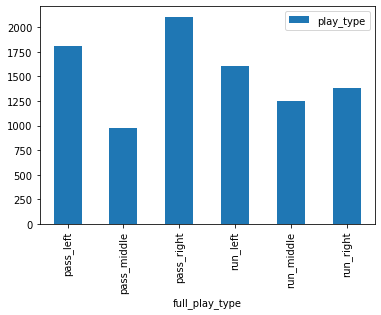

In [67]:
sf.groupby(['full_play_type']).count()[['play_type']].plot(kind='bar');

We can see that the 49ers offense runs 6 tyes of plays. If we wanted to predict what type of play the offense were to run next, we would have a 1/6 chance, or 16.67% chance, of correctly guessing the play. The goal of this project is to increase this chance by as much as possible through the implementation of a Random Forest Classifier.

In [69]:
pple = preprocessing.LabelEncoder()
pple.fit(sf.full_play_type)
sf['full_play_type_numeric'] = pple.transform(sf['full_play_type'])

I used the preprocessing library of sklearn to create a numeric representation of the "full play type" column (the column we are trying to predict), which is a more compatible format for my model.

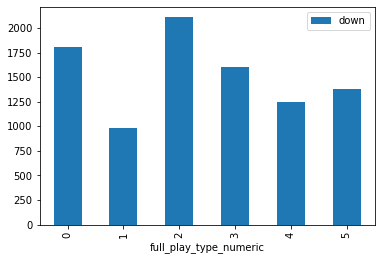

In [82]:
sf.groupby(['full_play_type_numeric']).count()[['down']].plot(kind='bar');

In [83]:
def bucketsize(val, size, count):
    i=0
    for i in range(count):
        if val <= (i+1)*size:
            return i
    return i
def bucketsize_df(df):
    df['ydstogo'] = [bucketsize(x, 4, 5) for x in df['ydstogo']]
    return df
sf = bucketsize_df(sf)

The function above allocates the "yards to go" column into buckets (1-5 yards, 6-10 yards, etc.) so that it's easier for the model to identify patterns.

In [84]:
sf = pd.concat([sf, pd.get_dummies(sf['down'], prefix='down')], axis=1)
sf = pd.concat([sf, pd.get_dummies(sf['ydstogo'], prefix='ydstogo')], axis=1)
sf['game_seconds_remaining']/=3600
sf['yardline_100']/=100
sf['score_differential']=(sf['score_differential']+50)/100
Y=sf['full_play_type_numeric']
X=sf[['yardline_100', 'shotgun', 'score_differential', 'game_seconds_remaining', 'down_1.0', 'down_2.0', 'down_3.0', 'down_4.0','ydstogo_0','ydstogo_1','ydstogo_2','ydstogo_3','ydstogo_4']]
Y.head()

1721    5
1722    4
1723    2
1730    0
1732    5
Name: full_play_type_numeric, dtype: int64

The cell above hot encodes the down and yards to go column, so that the down is now represented with 4 columns (each corresponding to the down) and the down that the yards to go is referring to is populated with a 1, whereas the other 3 down columns have a 0. This converts most of our data into numerical 0 and 1's which is more compatible with our model format. We also simplify the game_seconds_remaining, yardline_100 and score differential columns to a scale of zero and one, consistent with the other columns of our table. We also split the data into our input columns ('X') and our result column that we want to predict ('Y')

In [103]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y, random_state = 0)

Splitting the data into a train set and test set.

In [145]:
from sklearn.ensemble import RandomForestClassifier
the_clf=RandomForestClassifier(max_depth=8, n_estimators=64)
the_clf.fit(train_x, train_y)

RandomForestClassifier(max_depth=8, n_estimators=64)

In [146]:
from sklearn.metrics import accuracy_score
pred = the_clf.predict(test_x)
acc =accuracy_score(test_y, pred)

In [147]:
print(acc)

0.26763031099430573


After training the model and fitting our data, we can see that we correctly predict the 49ers plays about 27% of the time, which is a huge increase from randomly guessing plays. A confusion matrix of the model is displayed below.

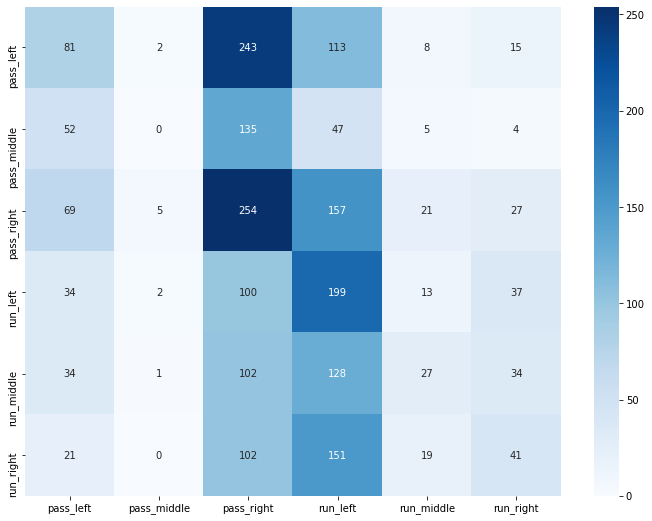

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, pred)

df_cm = pd.DataFrame(cm, index = [i for i in list(pple.classes_)],
                  columns = [i for i in list(pple.classes_)])
plt.figure(figsize = (12,9))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

Next steps for this project would include using our fitted data and testing it with more complex models.